In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mutual_info_score
from sklearn.feature_extraction import DictVectorizer
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')

In [3]:
print("Información del dataset:")
print(df.info())
print("\n" + "="*80)
print("Valores faltantes por columna:")
print(df.isnull().sum())
print("\n" + "="*80)
print("Tipos de datos:")
print(df.dtypes)

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB
None

Valores faltantes por columna:
lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
loc

In [4]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remover 'converted' de las listas si está presente
if 'converted' in numerical_cols:
    numerical_cols.remove('converted')
if 'converted' in categorical_cols:
    categorical_cols.remove('converted')

print(f"Columnas numéricas: {numerical_cols}")
print(f"Columnas categóricas: {categorical_cols}")

# Llenar valores faltantes
df_clean = df.copy()

# Categóricas: llenar con 'NA'
for col in categorical_cols:
    df_clean[col] = df_clean[col].fillna('NA')

# Numéricas: llenar con 0.0
for col in numerical_cols:
    df_clean[col] = df_clean[col].fillna(0.0)

print("\nValores faltantes después de limpiar:")
print(df_clean.isnull().sum().sum())

Columnas numéricas: ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
Columnas categóricas: ['lead_source', 'industry', 'employment_status', 'location']

Valores faltantes después de limpiar:
0


## What is the most frequent observation (mode) for the column industry?

In [17]:
mode_industry = df_clean['industry'].mode()[0]
print(f"\nModa de 'industry': {mode_industry}")

# Ver frecuencias
print(f"\nFrecuencias de 'industry':")
print(df_clean['industry'].value_counts().head(10))

print(f"\nRESPUESTA PREGUNTA 1: {mode_industry}")


Moda de 'industry': retail

Frecuencias de 'industry':
industry
retail           203
finance          200
other            198
healthcare       187
education        187
technology       179
manufacturing    174
NA               134
Name: count, dtype: int64

RESPUESTA PREGUNTA 1: retail


## What are the two features that have the biggest correlation?


Matriz de correlación:
                          number_of_courses_viewed  annual_income  \
number_of_courses_viewed                  1.000000       0.009770   
annual_income                             0.009770       1.000000   
interaction_count                        -0.023565       0.027036   
lead_score                               -0.004879       0.015610   

                          interaction_count  lead_score  
number_of_courses_viewed          -0.023565   -0.004879  
annual_income                      0.027036    0.015610  
interaction_count                  1.000000    0.009888  
lead_score                         0.009888    1.000000  


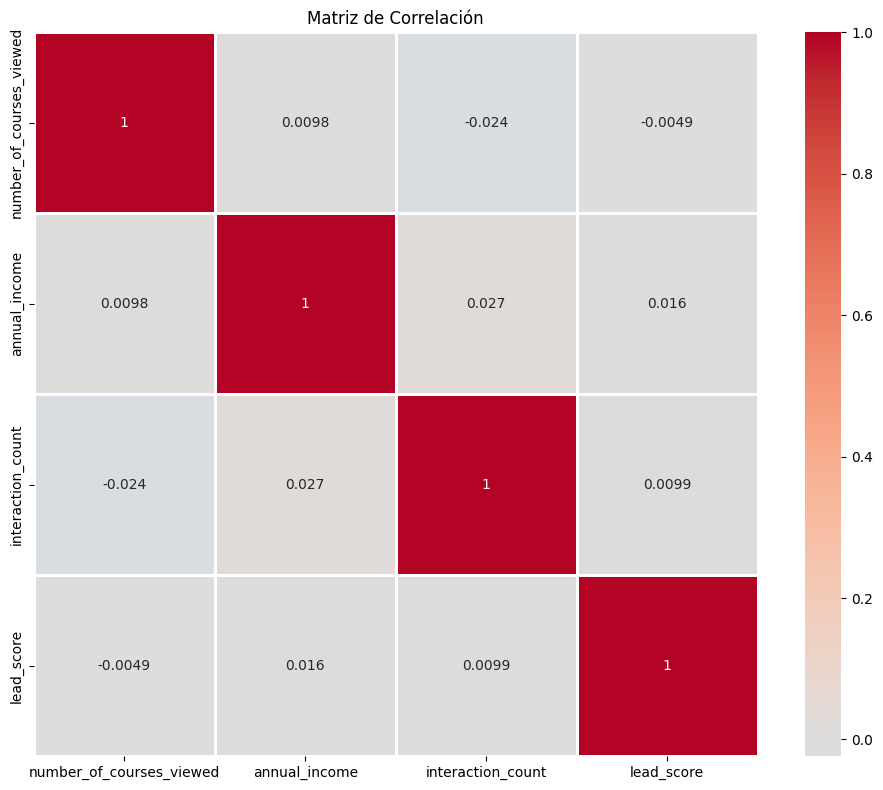


Correlaciones de los pares mencionados:
interaction_count vs lead_score: 0.0099
number_of_courses_viewed vs lead_score: -0.0049
number_of_courses_viewed vs interaction_count: -0.0236
annual_income vs interaction_count: 0.0270

 RESPUESTA PREGUNTA 2: annual_income - interaction_count tiene la mayor correlación: 0.0270


In [16]:
# Crear matriz de correlación solo con variables numéricas
correlation_matrix = df_clean[numerical_cols].corr()

print("\nMatriz de correlación:")
print(correlation_matrix)

# Visualizar matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1)
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.show()

# Verificar correlaciones específicas mencionadas en la pregunta
pairs_to_check = [
    ('interaction_count', 'lead_score'),
    ('number_of_courses_viewed', 'lead_score'),
    ('number_of_courses_viewed', 'interaction_count'),
    ('annual_income', 'interaction_count')
]

print("\nCorrelaciones de los pares mencionados:")
correlations = {}
for feat1, feat2 in pairs_to_check:
    if feat1 in correlation_matrix.columns and feat2 in correlation_matrix.columns:
        corr_value = correlation_matrix.loc[feat1, feat2]
        correlations[f"{feat1} - {feat2}"] = corr_value
        print(f"{feat1} vs {feat2}: {corr_value:.4f}")

# Encontrar la mayor correlación
max_pair = max(correlations, key=correlations.get)
max_corr = correlations[max_pair]

print(f"\n RESPUESTA PREGUNTA 2: {max_pair} tiene la mayor correlación: {max_corr:.4f}")

## Split the data

In [8]:
# Separar features y target
X = df_clean.drop('converted', axis=1)
y = df_clean['converted']

# Primera división: 60% train, 40% temp
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# Segunda división: 20% val, 20% test (del 40% temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"\nTrain set: {len(X_train_full)} muestras ({len(X_train_full)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val)} muestras ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} muestras ({len(X_test)/len(X)*100:.1f}%)")

print(f"\nDistribución del target en train:")
print(y_train_full.value_counts(normalize=True))

DIVISIÓN DEL DATASET

Train set: 877 muestras (60.0%)
Validation set: 292 muestras (20.0%)
Test set: 293 muestras (20.0%)

Distribución del target en train:
converted
1    0.610034
0    0.389966
Name: proportion, dtype: float64


## Which of these variables has the biggest mutual information score?

In [18]:
# Calcular mutual information para variables categóricas
mi_scores = {}

for col in categorical_cols:
    # Convertir a códigos numéricos para mutual_info_score
    X_encoded = X_train_full[col].astype('category').cat.codes
    mi = mutual_info_score(X_encoded, y_train_full)
    mi_scores[col] = round(mi, 2)

print("\nMutual Information Scores:")
for col, score in sorted(mi_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{col:25s}: {score:.2f}")

# Encontrar la variable con mayor MI
max_mi_var = max(mi_scores, key=mi_scores.get)
max_mi_score = mi_scores[max_mi_var]

print(f"\nRESPUESTA PREGUNTA 3: {max_mi_var} tiene el mayor MI score: {max_mi_score:.2f}")


Mutual Information Scores:
lead_source              : 0.03
industry                 : 0.02
employment_status        : 0.02
location                 : 0.00

RESPUESTA PREGUNTA 3: lead_source tiene el mayor MI score: 0.03


## What accuracy did you get?

In [11]:
print("="*80)
print("PREGUNTA 4: Logistic Regression")
print("="*80)

# Preparar datos con DictVectorizer para one-hot encoding
def prepare_X(df):
    """Convierte dataframe a diccionarios para DictVectorizer"""
    df_dict = df.to_dict(orient='records')
    return df_dict

# Preparar datos
train_dict = prepare_X(X_train_full)
val_dict = prepare_X(X_val)
test_dict = prepare_X(X_test)

# Crear DictVectorizer y ajustar en train
dv = DictVectorizer(sparse=False)
X_train_encoded = dv.fit_transform(train_dict)
X_val_encoded = dv.transform(val_dict)
X_test_encoded = dv.transform(test_dict)

print(f"\nShape después de encoding:")
print(f"X_train: {X_train_encoded.shape}")
print(f"X_val: {X_val_encoded.shape}")
print(f"X_test: {X_test_encoded.shape}")

# Entrenar modelo
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train_encoded, y_train_full)

# Predecir y calcular accuracy
y_val_pred = model.predict(X_val_encoded)
accuracy_val = accuracy_score(y_val, y_val_pred)
accuracy_val_rounded = round(accuracy_val, 2)

print(f"\n✓ RESPUESTA PREGUNTA 4: Accuracy en validación: {accuracy_val_rounded}")

PREGUNTA 4: Logistic Regression

Shape después de encoding:
X_train: (877, 31)
X_val: (292, 31)
X_test: (293, 31)

✓ RESPUESTA PREGUNTA 4: Accuracy en validación: 0.74


## Which of following feature has the smallest difference?

In [15]:
# Accuracy original (ya calculado en Q4)
original_accuracy = accuracy_val

print(f"\nAccuracy original (con todas las features): {original_accuracy:.6f}")

# Features a evaluar
features_to_test = ['industry', 'employment_status', 'lead_score']

# Diccionario para almacenar diferencias
accuracy_differences = {}

for feature in features_to_test:
    print(f"\nProbando sin feature: {feature}")
    
    # Crear datasets sin la feature
    X_train_temp = X_train_full.drop(feature, axis=1)
    X_val_temp = X_val.drop(feature, axis=1)
    
    # Preparar y encodear
    train_dict_temp = prepare_X(X_train_temp)
    val_dict_temp = prepare_X(X_val_temp)
    
    dv_temp = DictVectorizer(sparse=False)
    X_train_encoded_temp = dv_temp.fit_transform(train_dict_temp)
    X_val_encoded_temp = dv_temp.transform(val_dict_temp)
    
    # Entrenar modelo
    model_temp = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model_temp.fit(X_train_encoded_temp, y_train_full)
    
    # Predecir y calcular accuracy
    y_val_pred_temp = model_temp.predict(X_val_encoded_temp)
    accuracy_temp = accuracy_score(y_val, y_val_pred_temp)
    
    # Calcular diferencia
    diff = original_accuracy - accuracy_temp
    accuracy_differences[feature] = diff
    
    print(f"  Accuracy sin '{feature}': {accuracy_temp:.6f}")
    print(f"  Diferencia: {diff:.6f}")

print("\n" + "="*80)
print("RESUMEN - Diferencias de accuracy:")
for feature, diff in sorted(accuracy_differences.items(), key=lambda x: abs(x[1])):
    print(f"{feature:25s}: {diff:.6f}")

# Encontrar feature con menor diferencia (en valor absoluto)
min_diff_feature = min(accuracy_differences, key=lambda x: abs(accuracy_differences[x]))
min_diff_value = accuracy_differences[min_diff_feature]

print(f"\nRESPUESTA PREGUNTA 5: {min_diff_feature} tiene la menor diferencia: {min_diff_value:.6f}")


Accuracy original (con todas las features): 0.743151

Probando sin feature: industry
  Accuracy sin 'industry': 0.743151
  Diferencia: 0.000000

Probando sin feature: employment_status
  Accuracy sin 'employment_status': 0.746575
  Diferencia: -0.003425

Probando sin feature: lead_score
  Accuracy sin 'lead_score': 0.743151
  Diferencia: 0.000000

RESUMEN - Diferencias de accuracy:
industry                 : 0.000000
lead_score               : 0.000000
employment_status        : -0.003425

RESPUESTA PREGUNTA 5: industry tiene la menor diferencia: 0.000000


## Which of these C leads to the best accuracy on the validation set?

In [19]:
# Valores de C a probar
C_values = [0.01, 0.1, 1, 10, 100]
results = {}

print("\nResultados por valor de C:")
print("-" * 40)

for C in C_values:
    # Entrenar modelo
    model_reg = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    model_reg.fit(X_train_encoded, y_train_full)
    
    # Predecir y calcular accuracy
    y_val_pred_reg = model_reg.predict(X_val_encoded)
    accuracy_reg = accuracy_score(y_val, y_val_pred_reg)
    accuracy_reg_rounded = round(accuracy_reg, 3)
    
    results[C] = accuracy_reg_rounded
    print(f"C = {C:6.2f}  ->  Accuracy = {accuracy_reg_rounded:.3f}")

# Encontrar el mejor C (mayor accuracy, y si hay empate, el menor C)
max_accuracy = max(results.values())
best_C = min([c for c, acc in results.items() if acc == max_accuracy])

print("-" * 40)
print(f"\nRESPUESTA PREGUNTA 6: C = {best_C} da el mejor accuracy: {max_accuracy:.3f}")


Resultados por valor de C:
----------------------------------------
C =   0.01  ->  Accuracy = 0.743
C =   0.10  ->  Accuracy = 0.743
C =   1.00  ->  Accuracy = 0.743
C =  10.00  ->  Accuracy = 0.743
C = 100.00  ->  Accuracy = 0.743
----------------------------------------

RESPUESTA PREGUNTA 6: C = 0.01 da el mejor accuracy: 0.743
